In [3]:
import os
import sys

sys.path.append("/mnt/c/Projects/my-assistant")
from pipelines.stock_buddy.utils import get_current_datetime, get_stock_code

from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

from pipelines.stock_buddy.functions.finance import balance_sheet, income_statement, cash_flow, ratio 

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Helper utils

In [4]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Define Agent

In [57]:
import functools
import operator
from typing import List, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o-mini")

tavily_tool = TavilySearchResults(max_results=3)


current_datetime_agent = create_react_agent(llm, tools=[get_current_datetime], 
                                            state_modifier="Your task is to provide the time context for the conversation, you don't need to answer. \
                                                You only use the function get_current_datetime if user mentions a relative time \
                                                    like 'now', 'today', 'yesterday', 'tomorrow', 'etc'. \
                                                        Your answer must follow the format: 'The current date and time is current_date_time'.")
current_datetime_node = functools.partial(agent_node, agent=current_datetime_agent, name="CurrentDateTime")

check_stock_code_agent = create_react_agent(llm, tools=[tavily_tool], 
                                            state_modifier="Your task is to provide the code of to the context for the conversation if there is only company name and no stock code in the conversation,  \
                                                        Your answer must follow the format: 'The stock code of XXXXXXX is YYY'.")
check_stock_code_node = functools.partial(agent_node, agent=check_stock_code_agent, name="GetStockCode")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  CurrentDateTime, GetStockCode. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "If there is already a stock code in the conversation, the GetStockCode worker should not be called (The stock code normally is a uppercase string with 3 characters).",
    ["CurrentDateTime", "GetStockCode"],
)

In [58]:
preprocess_graph = StateGraph(ResearchTeamState)
preprocess_graph.add_node("CurrentDateTime", current_datetime_node)
preprocess_graph.add_node("GetStockCode", check_stock_code_node)
preprocess_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
preprocess_graph.add_edge("CurrentDateTime", "supervisor")
preprocess_graph.add_edge("GetStockCode", "supervisor")
preprocess_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"CurrentDateTime": "CurrentDateTime", "GetStockCode": "GetStockCode", "FINISH": END},
)


preprocess_graph.add_edge(START, "supervisor")
chain = preprocess_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


preprocess_chain = enter_chain | chain

In [38]:
preprocess_chain.invoke("Hôm nay là ngày mấy?")

{'messages': [HumanMessage(content='Hôm nay là ngày mấy?', id='09fa44d6-e235-4c04-9f7c-d125caa9dda1'),
  HumanMessage(content='The current date and time is 2024-09-19 23:45:23.', name='CurrentDateTime')],
 'next': 'FINISH'}

In [59]:
preprocess_chain.invoke("Giá cổ phiếu TCB hôm nay như thế nào?")

{'messages': [HumanMessage(content='Giá cổ phiếu TCB hôm nay như thế nào?', id='64eb3811-b3b6-405c-93cf-60c26baf8b41'),
  HumanMessage(content='The stock code of Vietnam Technological & Commercial JS Bank is TCB.', name='GetStockCode', id='95a6fe40-37e6-447f-807f-3060754b98b3'),
  HumanMessage(content='The current date and time is 2024-09-19 23:54:00.', name='CurrentDateTime')],
 'next': 'FINISH'}

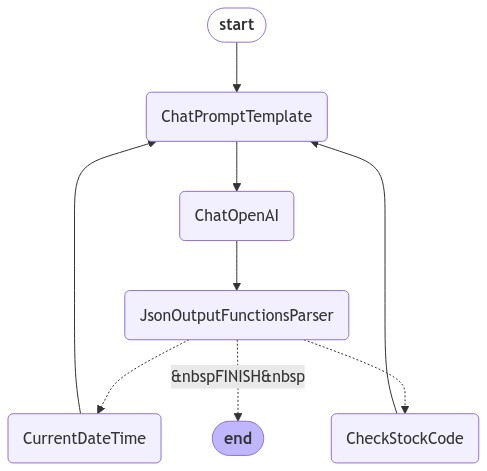

In [10]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))